# 自动着色算法之Colorization

当桃乐丝在1939年的电影《绿野仙踪》中走进奥兹国时，从黑白到鲜艳的色彩的转变使它成为电影史上最令人叹为观止的时刻之一。毫无疑问，颜色是一种有效的表达工具，但它们通常是有代价的。在制作现代动画电影和漫画时，图像着色是最费力和昂贵的阶段之一。自动着色过程可以帮助减少制作漫画或动画电影所需的成本和时间

## 模型简介

Colorization算法是来自加里福利亚大学的一项研究，采用的是CNN的结构。该算法可以实现灰度图像的自动着色，由Richard Zhang等人在论文Colorful Image Colorization中提出，并发表在2016年的ECCV会议中。该模型由8个conv层组成，每个conv层由2个或3个重复的卷积层和ReLU层组成，后面跟着一个BatchNorm层。网络中不包含池化层。

## 网络特点

1. 设计了一个合适的损失函数来处理着色问题中的多模不确定性，维持了颜色的多样性。

2. 将图像着色任务转化为一个自监督表达学习的任务。

3. 在一些基准模型上获得了最好的效果。

## 数据处理

开始实验之前，请确保本地已经安装了Python环境并安装了MindSpore Vision套件。

### 数据准备

本案例使用ImageNet数据集作为训练集和测试集。请在[官网](https://www.image-net.org)下载。训练集中包含1000个类别，总计大约120万张图片，测试集中包含5万图片。

解压后的数据集目录结构如下：

```text

.dataset/
    ├── ILSVRC2012_devkit_t12.tar.gz
    ├── train/
    └── val/

```

### 训练集可视化


177


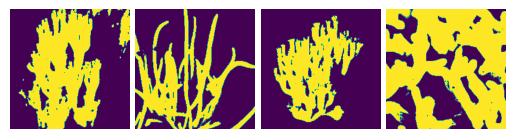

In [1]:
import os
import argparse
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import mindspore
from src.process_datasets.data_generator import ColorizationDataset


#加载参数
parser = argparse.ArgumentParser()
parser.add_argument('--image_dir', type=str, default='./dataset/train', help='path to dataset')
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--num_parallel_workers', type=int, default=1)
parser.add_argument('--shuffle', type=bool, default=True)
args = parser.parse_args(args=[])
plt.figure()

#加载数据集
dataset = ColorizationDataset(args.image_dir, args.batch_size, args.shuffle, args.num_parallel_workers)
data = dataset.run()
show_data = next(data.create_tuple_iterator())
show_images_original, _ = show_data
show_images_original = show_images_original.asnumpy()
#循环处理
for i in range(1, 5):
    plt.subplot(1, 4, i)
    temp = show_images_original[i-1]
    temp = np.clip(temp, 0, 1)
    plt.imshow(temp)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0)


## 构建网络

处理完数据后进行网络的搭建，Colorization的网络结构较为简单，采用CNN的网络结构。具体结构如下图所示

<center>

![](./images/network.png)
</center>
网络的详细配置为：

<center>

![](./images/netdetail.png)
</center>

其中X输出的空间分辨率，C输出的通道数;S计算步幅，大于1表示卷积后下采样，小于1表示卷积前上采样;D内核扩张;Sa在所有前一层的累积步数(积于前一层的所有步数);相对于输入的层的有效膨胀(层膨胀乘以累积步幅);BN层后是否使用BatchNorm层;L表示是否施加了1x1的卷积和交叉熵损失层。

In [ ]:
import mindspore
import mindspore.nn as nn
from mindspore.common.initializer import initializer
from initializer import XavierNormal


class ColorizationModel(nn.Cell):
    """
    Network.

    Inputs:
        - **input_l** (tensor) - Tensor generated by L channel of input images.

    OutPuts:
        Infer output tensor.

    Examples:
        >>> net = ColorizationModel()

    """

    def __init__(self):
        super(ColorizationModel, self).__init__()
        weight_init = XavierNormal(gain=1.0)
        self.model = nn.SequentialCell()
        self.model.append(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [64], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [64], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(64))

        self.model.append(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [128], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [128], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(128))

        self.model.append(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [256], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [256], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [256], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(256))

        self.model.append(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, pad_mode="pad", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(512))

        self.model.append(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, pad_mode="pad",
                                    has_bias=True, weight_init=weight_init,
                                    bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, pad_mode="pad",
                                    has_bias=True, weight_init=weight_init,
                                    bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, pad_mode="pad",
                                    has_bias=True, weight_init=weight_init,
                                    bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(512))

        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(512))

        self.model.append(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(512, 512, kernel_size=3, dilation=1, stride=1, padding=1, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [512], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.BatchNorm2d(512))

        self.model.append(
            nn.Conv2dTranspose(512, 256, kernel_size=4, dilation=1, stride=2, padding=1, pad_mode="pad",
                               has_bias=True, weight_init=weight_init,
                               bias_init=initializer(0.1, [256], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(256, 256, kernel_size=3, dilation=1, stride=1, padding=1, pad_mode="pad", has_bias=True,
                      weight_init=weight_init, bias_init=initializer(0.1, [256], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(
            nn.Conv2d(256, 256, kernel_size=3, dilation=1, stride=1, padding=1, pad_mode="pad",
                      has_bias=True, weight_init=weight_init, bias_init=initializer(0.1, [256], mindspore.float32)))
        self.model.append(nn.ReLU())
        self.model.append(nn.Conv2d(256, 313, kernel_size=1, dilation=1, stride=1, pad_mode="valid", has_bias=True,
                                    weight_init=weight_init, bias_init=initializer(0.1, [313], mindspore.float32)))

    def construct(self, input_l):
        """ build network """
        features = self.model(input_l) / 0.38
        return features



## 损失函数

该算法将上色问题视为一个分类问题。首先将ab通道的输出空间以10为步长量化为Q=313类，对于给定的输入$X$,学习到一个颜色概率分布$\hat Z\in[0,1]^{H\times W\times Q}$的映射$\hat Z=G(X)$

<center>

![](./images/colordegree.png)
</center>

为了比价预测的结果$\hat Z$和真实值的差距，我们定义一个函数$Z=H^{-1}_{gt}(Y)$将真实颜色$Y$转换成向量$Z$（通过搜索最接近的分类将Y变为One-Hot向量）。论文中的soft_encoding scheme是指在313类的输出空间中找到$Y_{h,w}$的5个最近邻，并按照它们距离$Y_{h,w}$的距离按比例进行高斯加权。最后使用多分类交叉熵作为损失函数：

$$L_{cl}(\hat Z,Z)=-\sum_{h,w}v(Z_{h,w})\sum_{q}Z_{h,w,q}log(\hat Z_{h,w,q})$$

其中$v(\cdot)$是用来平衡那些出现频率较少的类的权重。最后再使用函数$\hat Y=H(\hat Z)$.将预测得到的概率分布$Z$映射到具体的颜色值$\hat Y$。

## 分类再平衡

由于由于云朵、路面、沙漠等经常大面积地作为背景出现在图片中，自然图像中ab的取值倾向于较小的方向。下图是从130万的数据集中统计的ab取值分布，可以发现自然图片中取值都集中在不饱和区域，如果不考虑这个问题，那损失函数将会被不饱和的ab取值主导。

<center>

![](./images/colorweight.jpg)
</center>

为了处理这问题，作者在训练的时候为每个像素的loss重新调整权重，这个权重的大小是基于像素颜色的稀有度来设置的：

$$v(Z_{h,w})=\omega_{q*}$$

$$q^*={argmax}_qZ_{h,w,q}$$

$$\omega\propto((1-\lambda)\tilde p + \frac {\lambda}{Q})^{-1}$$

$$E[\omega]=\sum_q\tilde p_q \omega_q=1$$

为了得到平滑的经验分布$\tilde p  {\in}{\Delta}^{Q}$,作者统计了ImageNet训练集的a b abab概率分布，并使用高斯核$G_\sigma$进行平滑。然后再用权重为$\lambda \in[0,1]$的均匀分布进行混合并进行归一化。作者发现$\lambda = \frac{1}{2}$，$\sigma=5$时效果比较好。

## 分类概率到点估计

最后，我们定义函数$H$，将预测的概率分布$\hat{Z}$映射到ab空间的点估计$\hat{Y}$。作者通过在softmax分布中引入参数$T$，然后取结果的平均值：

$$H(Z_{h,w}=E[f_T(Z_{h,w})])$$

$$f_T(z)=\frac{exp(log(z)/T)}{\sum_q{exp(log(z_q)/T)}}$$

参数$T$的选择借鉴模拟退火的思想，最终选定$T=0.38$。

In [ ]:
class NetLoss(nn.Cell):
    """连接网络和损失"""
    def __init__(self, net):
        super(NetLoss, self).__init__(auto_prefix=True)
        self.net = net
        self.loss = nn.CrossEntropyLoss(reduction='none')

    def construct(self, images, targets, boost, mask):
        """ build network """
        outputs = self.net(images)
        boost_nongray = boost * mask
        squeeze = mindspore.ops.Squeeze(1)
        boost_nongray = squeeze(boost_nongray)
        result = self.loss(outputs, targets)
        result_loss = (result * boost_nongray).mean()
        return result_loss

## 模型实现

MindSpore要求将损失函数、优化器等操作也看做nn.Cell的子类，所以我们可以自定义Color类，将网络和loss连接起来。

In [ ]:
class ColorModel(nn.Cell):
    """定义Colorization网络"""

    def __init__(self, my_train_one_step_cell_for_net):
        super(ColorModel, self).__init__(auto_prefix=True)
        self.my_train_one_step_cell_for_net = my_train_one_step_cell_for_net

    def construct(self, result, targets, boost, mask):
        loss = self.my_train_one_step_cell_for_net(result, targets, boost,
                                                   mask)
        return loss

## 算法流程

![](./images/flowchart.jpg)

### 模型训练

实例化损失函数，优化器，使用Model接口编译网络，开始训练。

In [3]:
import argparse
import os
from tqdm import tqdm

import mindspore
import mindspore.nn as nn
from mindspore import context
from mindspore import ops
import numpy as np
import matplotlib.pyplot as plt
from src.utils.utils import PriorBoostLayer, NNEncLayer, NonGrayMaskLayer, decode

from src.model.model import ColorizationModel
from src.model.colormodel import ColorModel
from src.process_datasets.data_generator import ColorizationDataset
from src.losses.loss import NetLoss
import warnings

warnings.filterwarnings('ignore')
#加载参数

parser = argparse.ArgumentParser()
parser.add_argument('--device_target',
                    default='GPU',
                    choices=['CPU', 'GPU', 'Ascend'],
                    type=str)
parser.add_argument('--device_id', default=1, type=int)
parser.add_argument('--image_dir',
                    type=str,
                    default='./dataset/train',
                    help='path to dataset')
parser.add_argument('--checkpoint_dir',
                    type=str,
                    default='./checkpoints',
                    help='path for saving trained model')
parser.add_argument('--test_dirs',
                    type=str,
                    default='./images',
                    help='path for saving trained model')
parser.add_argument('--resource', type=str, default='./src/resources/')
parser.add_argument('--shuffle', type=bool, default=True)
parser.add_argument('--num_epochs', type=int, default=2)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--num_parallel_workers', type=int, default=1)
parser.add_argument('--learning_rate', type=float, default=0.5e-4)
parser.add_argument('--save_step',
                    type=int,
                    default=200,
                    help='step size for saving trained models')
args = parser.parse_args(args=[])

if context.get_context('device_id') != args.device_id:
    context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target, device_id=args.device_id)

encode_layer = NNEncLayer(args)
boost_layer = PriorBoostLayer(args)
non_gray_mask = NonGrayMaskLayer()

#网络实例化
net = ColorizationModel()

#设置优化器
net_args = nn.Adam(net.trainable_params(), learning_rate=args.learning_rate)

#实例化NetLoss
net_with_criterion = NetLoss(net)

#实例化TrainOneStepWithLossScaleCell
scale_sense = nn.FixedLossScaleUpdateCell(1)
myTrainOneStepCellForNet = nn.TrainOneStepWithLossScaleCell(
    net_with_criterion, net_args, scale_sense=scale_sense)
colormodel = ColorModel(myTrainOneStepCellForNet)
colormodel.set_train()

#加载数据集
dataset = ColorizationDataset(args.image_dir, args.batch_size, args.shuffle,
                              args.num_parallel_workers)
data = dataset.run().create_tuple_iterator()

for epoch in range(args.num_epochs):
    iters = 0

    #为每轮训练读入数据
    for images, img_ab in tqdm(data):
        images = ops.expand_dims(images, 1)
        encode, max_encode = encode_layer.forward(img_ab)
        targets = mindspore.Tensor(max_encode, dtype=mindspore.int32)
        boost = mindspore.Tensor(boost_layer.forward(encode),
                                 dtype=mindspore.float32)
        mask = mindspore.Tensor(non_gray_mask.forward(img_ab),
                                dtype=mindspore.float32)
        net_loss = colormodel(images, targets, boost, mask)
        #输出训练数据
        print('[%d/%d]\tLoss_net:: %.4f' % (epoch + 1, args.num_epochs, net_loss[0]))
        #中间保存训练结果
        if iters % args.save_step == 0:
            if not os.path.exists(args.checkpoint_dir):
                os.makedirs(args.checkpoint_dir)
            mindspore.save_checkpoint(
                net,
                os.path.join(args.checkpoint_dir, 'net' + str(epoch + 1) + '_' +
                             str(iters) + '.ckpt'))
            img_ab_313 = net(images)
            out_max = np.argmax(img_ab_313[0].asnumpy(), axis=0)
            color_img = decode(images, img_ab_313, args.resource)
            if not os.path.exists(args.test_dirs):
                os.makedirs(args.test_dirs)
            plt.imsave(
                args.test_dirs + '/' + str(epoch + 1) + '_' + str(iters) +
                '%s_infer.png', color_img)
        iters = iters + 1

1300


0it [00:00, ?it/s]

[1/2]	Loss_net:: 5.5346


2it [00:03,  1.62s/it]

[1/2]	Loss_net:: 3.7180


3it [00:04,  1.02s/it]

[1/2]	Loss_net:: 5.3768


4it [00:04,  1.35it/s]

[1/2]	Loss_net:: 3.6886


5it [00:04,  1.70it/s]

[1/2]	Loss_net:: 7.7439


6it [00:05,  2.03it/s]

[1/2]	Loss_net:: 5.4509


7it [00:05,  2.30it/s]

[1/2]	Loss_net:: 4.5073


8it [00:05,  2.52it/s]

[1/2]	Loss_net:: 4.2895


9it [00:05,  2.68it/s]

[1/2]	Loss_net:: 5.5411


10it [00:06,  2.83it/s]

[1/2]	Loss_net:: 4.9895


11it [00:06,  2.92it/s]

[1/2]	Loss_net:: 7.6533


12it [00:06,  2.97it/s]

[1/2]	Loss_net:: 7.8137


13it [00:07,  3.00it/s]

[1/2]	Loss_net:: 4.9175


14it [00:07,  3.05it/s]

[1/2]	Loss_net:: 3.9061


15it [00:07,  3.08it/s]

[1/2]	Loss_net:: 5.5722


16it [00:08,  3.10it/s]

[1/2]	Loss_net:: 4.4963


17it [00:08,  3.11it/s]

[1/2]	Loss_net:: 6.7354


18it [00:08,  2.96it/s]

[1/2]	Loss_net:: 3.7584


19it [00:09,  2.88it/s]

[1/2]	Loss_net:: 5.3417


20it [00:09,  2.84it/s]

[1/2]	Loss_net:: 5.3063


21it [00:09,  2.92it/s]

[1/2]	Loss_net:: 4.6485


22it [00:10,  2.99it/s]

[1/2]	Loss_net:: 5.9853


23it [00:10,  2.91it/s]

[1/2]	Loss_net:: 3.6890


24it [00:11,  2.87it/s]

[1/2]	Loss_net:: 2.8398


25it [00:11,  2.90it/s]

[1/2]	Loss_net:: 2.7970


26it [00:11,  2.95it/s]

[1/2]	Loss_net:: 7.5539


27it [00:12,  2.97it/s]

[1/2]	Loss_net:: 5.1613


: 

: 

![batch_size=128,epoch=44时的训练结果](./images/44_1600_infer.png)

## 模型推理

运行下面代码，将一张灰度图像输入到网络中，即可生成具有合理色彩的图像。

In [1]:
import argparse
import os

import matplotlib.pyplot as plt
import mindspore
import numpy as np
from mindspore import (context, load_checkpoint, load_param_into_net, ops)
from mindspore.train.model import Model
from tqdm import tqdm

from src.model.model import ColorizationModel
from src.process_datasets.data_generator import ColorizationDataset
from src.utils.utils import decode


parser = argparse.ArgumentParser()
parser.add_argument('--img_path', type=str, default='./dataset/val')
parser.add_argument('--ckpt_path', type=str, default='./checkpoints/net44_1600.ckpt')
parser.add_argument('--resource', type=str, default='./src/resources/')
parser.add_argument('--device_target', default='GPU', choices=['CPU', 'GPU', 'Ascend'], type=str)
parser.add_argument('--device_id', default=1, type=int)
parser.add_argument('--infer_dirs', default='./dataset/output', type=str)
args = parser.parse_args(args=[])


mindspore.context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target, device_id=args.device_id)

#实例化网络
net = ColorizationModel()

#加载参数
param_dict = load_checkpoint(args.ckpt_path)
load_param_into_net(net, param_dict)
colorizer = Model(net)
dataset = ColorizationDataset(args.img_path, 1, prob=0)
data = dataset.run().create_tuple_iterator()
iters = 0

if not os.path.exists(args.infer_dirs):
    os.makedirs(args.infer_dirs)

#循环处理图像
for images, img_ab in tqdm(data):
    images = ops.expand_dims(images, 1)
    img_ab_313 = colorizer.predict(images)
    out_max = np.argmax(img_ab_313[0].asnumpy(), axis=0)
    color_img = decode(images, img_ab_313, args.resource)
    plt.imsave(args.infer_dirs+'/'+str(iters)+'_infer.png', color_img)
    iters = iters + 1

[WARNING] ME(919987:139830620148032,MainProcess):2022-11-02-20:50:39.280.694 [mindspore/train/serialization.py:734] For 'load_param_into_net', remove parameter prefix name: my_train_one_step_cell_for_net.net.model., continue to load.
[WARNING] ME(919987:139830620148032,MainProcess):2022-11-02-20:50:39.282.061 [mindspore/train/serialization.py:734] For 'load_param_into_net', remove parameter prefix name: my_train_one_step_cell_for_net.network.net.model., continue to load.


11


1it [00:01,  1.33s/it]/home/nf438/.conda/envs/smx3.7/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 87 pixels
  return func(*args, **kwargs)
3it [00:01,  2.61it/s]/home/nf438/.conda/envs/smx3.7/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)
/home/nf438/.conda/envs/smx3.7/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return func(*args, **kwargs)
6it [00:01,  5.59it/s]/home/nf438/.conda/envs/smx3.7/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 27 pixels
  return func(*args, **kwargs)
/home/nf438/.conda/envs/smx3.7/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 55 pixels
  return func(*args, **kwargs)
9it [00:01,  8.53it/s]/home/nf438/.conda/envs/smx3.

模型推理结果:  
![推理结果对比](./images/infer.png)

## 总结

本案例对Colorful Image Colorization文中提出的模型进行了详细的解释，向读者完整地展现了该算法的流程，分析了Colorization在着色方面的优势和存在的不足。如需查看详细代码，可参考MindSpore Vision套件。

## 引用

[1] Richard Zhang, Phillip Isola, and Alexei A Efros. Colorful image colorization. In ECCV, pages 649–666. Springer, 2016.<br>
[2] Richard Zhang, Jun-Y an Zhu, Phillip Isola, Xinyang Geng, Angela S Lin, Tianhe Y u, and Alexei A Efros. Real-time user-guided image colorization with learned deep priors. ACM Transactions on Graphics, 36(4):1–11.<br>
[3] Gustav Larsson, Michael Maire, and Gregory Shakhnarovich. Learning representations for automatic colorization. In IEEE ECCV, pages 577–593. Springer, 2016.<br>
[4] Y u-Wing Tai, Jiaya Jia, and Chi-Keung Tang. Local color transfer via probabilistic segmentation by expectation-maximization. In IEEE CVPR, volume 1, pages 747–754.IEEE, 2005.<br>
[5] Patterson, G. Hays, J.: Sun attribute database: Discovering, annotating, and recognizing scene attributes. In: Computer Vision and Pattern Recognition (CVPR), 2012 IEEE Conference on, IEEE (2012) 2751–2758.<br>